In [3]:
!pip install sentencepiece
!pip install transformers
#!pip install lightgbm

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 778kB 2.6MB/s 
     |████████████████████████████████| 890kB 8.7MB/s 
     |████████████████████████████████| 3.0MB 16.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=06beff4e5a9f6ef1cc6b50d9d19f164e495ece6663867b5ce46348b390c652b3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import datetime
import random
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, MaxPooling1D, Conv1D, Flatten, Dense, SpatialDropout1D, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization, Input, Concatenate, LSTM, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import Constant, glorot_uniform
from tensorflow.keras.metrics import MSE
import tensorflow as tf
import tensorflow_hub as hub
import tokenization
from transformers import BertTokenizer, BertConfig, TFBertModel, AlbertTokenizer, TFAlbertModel, AlbertConfig
import os
%load_ext tensorboard

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/5504%2F8240%2Fcompressed%2Fglove.6B.300d.txt.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1592315214&Signature=kQBwMrQWdL4FgMYEGYFgNKkDGTM49L3cgybZwWabZUCa03txEIzBa7YVmX2B0mbcqF232PC%2FDHalE7m9OsfEy%2Fwd%2FvWhR8Mc3ynMQEE9RasQXDZiYXTWJXcbZ%2BIbPMOv0eW6MPr5uCb13P6LxFCsHt%2F40tTcwVw9oxIUwaO1gaQUU3zdzJqwLAQyfMd%2BD8FP22sz2BpvzCNiUw2st6ApMpnZO5cuK6fE5ZqPq7uHYUXslhfjvIc8x14zkAlprW0wOLM5gQomZxchMBEj%2BA0E3AsvY2wWgi46AxUgpGR1vHTJyln%2Fi71yNu8316AONHtVMAk%2F%2F3X4MwAslcZDL6fuSg%3D%3D" -c -O '5504_8240_compressed_glove.6B.300d.txt.zip'
#import zipfile
#path_to_zip_file = '5504_8240_compressed_glove.6B.300d.txt.zip'
#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#    zip_ref.extractall()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Self Case study 2'

/content/drive/My Drive/Self Case study 2


In [5]:
np.random.seed(42)
tf.random.set_seed(32)
random.seed(12)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_col = list(train.columns)
qa_input_cols = train_col[:11] #Input features
q_target_cols = train_col[11:32] #Question related target labels
a_target_cols  = train_col[32:41] #Answer related target labels

In [ ]:
def preprocess(train, test):    

    def word_tokens_length(text):
        '''Tokenize each item in the text column and return length of the tokens'''
        word_tokens = word_tokenize(text)
        return len(word_tokens)

    #Getting only the first word of the host to get the host category
    train['host_cat'] = train.host.apply(lambda x:x.split('.')[0])
    train.drop('host', axis=1, inplace=True)
    test['host_cat'] = test.host.apply(lambda x:x.split('.')[0])
    test.drop('host', axis=1, inplace=True)

    # Create a new feature for the lengh of each question/answer
    train['question_n_words'] = train.question_body.apply(word_tokens_length)
    train['answer_n_words'] = train.answer.apply(word_tokens_length)
    train['questitle_n_words'] = train.question_title.apply(word_tokens_length)

    test['question_n_words'] = test.question_body.apply(word_tokens_length)
    test['answer_n_words'] = test.answer.apply(word_tokens_length)
    test['questitle_n_words'] = test.question_title.apply(word_tokens_length)
    
    # Create a new feature for the number of unique words in each question/answer
    train['question_number_count'] = train.question_body.apply(lambda x:sum(c.isdigit() for c in x))
    train['answer_number_count'] = train.answer.apply(lambda x:sum(c.isdigit() for c in x))
    train['question_unique_word']=train["question_body"].apply(lambda x: len(set(str(x).split())))
    train['answer_unique_word']=train.answer.apply(lambda x: len(set(str(x).split())))

    # Create a new feature for the number of numbers in each question/answer
    test['question_number_count'] = test.question_body.apply(lambda x:sum(c.isdigit() for c in x))
    test['answer_number_count'] = test.answer.apply(lambda x:sum(c.isdigit() for c in x))
    test['question_unique_word']=test.question_body.apply(lambda x: len(set(str(x).split())))
    test['answer_unique_word']=test.answer.apply(lambda x: len(set(str(x).split())))

    #https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-vis-bert

    puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>',
              '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£','·', '_', '{', '}', '©', '^', '®', '`', 
              '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
              '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
              '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',  '▒', '：', '¼', '⊕', '▼', '▪', '†', '■',
              '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
              '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬',
              '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', 'lt', 'gt', 'amp', 'div', 'ex', 'le', 'http', 'www', 'vo', '\n'
             ]

    def decontract(text):
        '''Decontracts the contracted words'''
        text = str(text)
        text = re.sub(r"(W|w)on(\'|\’)t ", "will not ", text)
        text = re.sub(r"(C|c)an(\'|\’)t ", "can not ", text)
        text = re.sub(r"(Y|y)(\'|\’)all ", "you all ", text)
        text = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", text)
        text = re.sub(r"(I|i)(\'|\’)m ", "i am ", text)
        text = re.sub(r"(A|a)isn(\'|\’)t ", "is not ", text)
        text = re.sub(r"n(\'|\’)t ", " not ", text)
        text = re.sub(r"(\'|\’)re ", " are ", text)
        text = re.sub(r"(\'|\’)d ", " would ", text)
        text = re.sub(r"(\'|\’)ll ", " will ", text)
        text = re.sub(r"(\'|\’)t ", " not ", text)
        text = re.sub(r"(\'|\’)ve ", " have ", text)
        return text

    def clean_text(x):
        '''Cleaning text of HTML, punctuations, special characters'''
        x = str(x)
        x = BeautifulSoup(x).get_text() #Removes HTML tags
        for punct in "/-'&":
            x = x.replace(punct, ' ')
        #Removes all the punctuations and other special characters
        for punct in puncts:
            x = x.replace(punct, ' ')
        return x

    def clean_numbers(x):
        '''Remove numbers from the questions and answers'''
        x = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", x)
        return x

    def preprocess_text(x):
        '''Does the text preprocessing at each question/answer level'''
        x= decontract(x)
        x=clean_text(x)
        x=clean_numbers(x)
        return x

    tqdm.pandas()
    train['question_body'] = train['question_body'].progress_apply(lambda q: preprocess_text(q))
    train['answer'] = train['answer'].progress_apply(lambda q: preprocess_text(q))
    train['question_title'] = train['question_title'].progress_apply(lambda q: preprocess_text(q))


    test['question_body'] = test['question_body'].progress_apply(lambda q: preprocess_text(q))
    test['answer'] = test['answer'].progress_apply(lambda q: preprocess_text(q))
    test['question_title'] = test['question_title'].progress_apply(lambda q: preprocess_text(q))
    
    return train, test

train, test = preprocess(train, test)

100%|██████████| 476/476 [00:00<00:00, 2524.36it/s]


In [ ]:
columns  = ['question_body', 'answer', 'question_title', 'question_n_words', 'answer_n_words',\
            'questitle_n_words', 'question_number_count', 'answer_number_count', 'question_unique_word',\
            'answer_unique_word', 'host_cat', 'category']
X = train[columns]
y = train[q_target_cols+a_target_cols]
X_test = test[columns]
X_train_full = X.copy()
y_train_full = y.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape)

In [6]:
#pickle.dump((X_train, y_train, X_train_full, y_train_full),open('train_data.pkl','wb'))
#pickle.dump((X_valid, y_valid),open('valid_data.pkl','wb'))
#pickle.dump((X_test),open('test_data.pkl','wb'))

X_train_full, y_train_full = pickle.load(open("train_data.pkl", 'rb'))
#X_valid, y_valid = pickle.load(open("valid_data.pkl", 'rb'))
X_test = pickle.load(open("test_data.pkl", 'rb'))

In [7]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf-8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
glove_model = loadGloveModel('glove.6B.300d.txt')


#https://stackoverflow.com/questions/51699001/tokenizer-texts-to-sequences-keras-tokenizer-gives-almost-all-zeros
#Embedding for creating embedding for texts#
def create_text_embedding(data, vocabulary_size, max_sequence_length, name= '', data_type = ''):
    '''Creating embeddings for the text features using GloVe'''
    if data_type=='train':
        tokenizer = Tokenizer(filters='', num_words=vocabulary_size, split=' ')
        tokenizer.fit_on_texts(data)
        filename = 'tokenizer_train_'+name+'.pkl'
        pickle.dump(tokenizer, open(filename, "wb"))
    elif data_type=='train_full':
        tokenizer = Tokenizer(filters='', num_words=vocabulary_size, split=' ')
        tokenizer.fit_on_texts(data)
        filename = 'tokenizer_train_full_'+name+'.pkl'
        pickle.dump(tokenizer, open(filename, "wb"))
    elif data_type=='valid':
        tokenizer = pickle.load(open('tokenizer_train_'+name+'.pkl', 'rb'))
    else:
        tokenizer = pickle.load(open('tokenizer_train_full_'+name+'.pkl', 'rb'))

    data_seq = tokenizer.texts_to_sequences(data)

    data_seq = np.asarray(pad_sequences(data_seq, maxlen= max_sequence_length, padding='post'))

    #https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
    #https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    embedding_dim = 300
    word_index = tokenizer.word_index
    num_words = min(vocabulary_size, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= vocabulary_size:
            continue
        embedding_vector = glove_model.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words, data_seq

global embedding_q_title_full, num_words_q_title_full, embedding_q_body_full, num_words_q_body_full,\
     embedding_answer_full, num_words_answer_full, non_text_len_full
### Question title embedding ##

embedding_q_title_full, num_words_q_title_full, sequence_train_full_q_title = create_text_embedding(
    X_train_full.question_title, vocabulary_size = 7500, max_sequence_length= 50, name = 'q_title', data_type = 'train_full')

### Question body embedding ##

embedding_q_body_full, num_words_q_body_full, sequence_train_full_q_body = create_text_embedding(
    X_train_full.question_body, vocabulary_size = 25000, max_sequence_length= 1000,  name = 'q_body',  data_type = 'train_full')

### Answer embedding ##

embedding_answer_full, num_words_answer_full, sequence_train_full_answer = create_text_embedding(
    X_train_full.answer, vocabulary_size = 35000, max_sequence_length= 1000,  name = 'answer',  data_type = 'train_full')


#Encoding for host categories
tokenizer_host_cat_full = Tokenizer(filters='')
tokenizer_host_cat_full.fit_on_texts(X_train_full.host_cat)
pickle.dump(tokenizer_host_cat_full, open('tokenizer_host_category.pkl', "wb"))

unique_host_cat_full = len(tokenizer_host_cat_full.word_index)+1
sequences_train = tokenizer_host_cat_full.texts_to_sequences(X_train_full.host_cat)
sequences_test = tokenizer_host_cat_full.texts_to_sequences(X_test.host_cat)


sequences_train_full_host_cat_ohe = tokenizer_host_cat_full.texts_to_matrix(X_train_full.host_cat)
sequences_test_host_cat_ohe = tokenizer_host_cat_full.texts_to_matrix(X_test.host_cat)

sequences_train_full_host_cat_ohe = np.asarray(pad_sequences(sequences_train_full_host_cat_ohe, maxlen= unique_host_cat_full))
sequences_test_host_cat_ohe = np.asarray(pad_sequences(sequences_test_host_cat_ohe, maxlen= unique_host_cat_full))

#Encoding for categories
tokenizer_cat_full = Tokenizer(filters='')
tokenizer_cat_full.fit_on_texts(X_train_full.category)
pickle.dump(tokenizer_cat_full, open('tokenizer_category.pkl', "wb"))

unique_cat_full = len(tokenizer_cat_full.word_index)+1
sequences_train = tokenizer_cat_full.texts_to_sequences(X_train_full.category)
sequences_test = tokenizer_cat_full.texts_to_sequences(X_test.category)

sequences_train_full_cat_ohe = tokenizer_cat_full.texts_to_matrix(X_train_full.category)
sequences_test_cat_ohe = tokenizer_cat_full.texts_to_matrix(X_test.category)

sequences_train_full_cat_ohe = np.asarray(pad_sequences(sequences_train_full_cat_ohe, maxlen= unique_cat_full))
sequences_test_cat_ohe = np.asarray(pad_sequences(sequences_test_cat_ohe, maxlen= unique_cat_full))

### Normalizing the numerical features ###
scalar = MinMaxScaler()
num_columns = ['question_n_words', 'answer_n_words', 'questitle_n_words', 'question_number_count',
              'answer_number_count', 'question_unique_word', 'answer_unique_word']

for col in num_columns:
    scalar.fit(X_train_full[col].values.reshape(-1, 1))
    filename = 'minmax_'+col+'.pkl'
    pickle.dump(scalar, open(filename, "wb"))
    X_train_full[col] = scalar.transform(X_train_full[col].values.reshape(-1, 1))
    #X_test[col] = scalar.transform(X_test[col].values.reshape(-1, 1))

### Concatenating the numerical features ###
sequences_train_full_rem = np.asarray([X_train_full[col].values for col in num_columns]).transpose()
sequences_test_rem =np.asarray([X_test[col].values for col in num_columns]).transpose()


### Concatenating the numerical and categorical features ###
non_text_len_full = unique_cat_full+ unique_host_cat_full+7
sequences_train_non_text_full = np.concatenate([sequences_train_full_cat_ohe, sequences_train_full_host_cat_ohe,
                                        sequences_train_full_rem], axis = 1).reshape(len(X_train_full), 73,1)
sequences_test_non_text = np.concatenate([sequences_test_cat_ohe, sequences_test_host_cat_ohe,
                                        sequences_test_rem], axis = 1).reshape(len(X_test), 73,1)

0it [00:00, ?it/s]

Loading Glove Model


400000it [00:52, 7621.92it/s]


Done. 400000  words loaded!


In [8]:
#https://www.kaggle.com/buntyshah/google-quest-q-a-labeling-8-fold
def spearmanr_score(trues, preds):
    '''Returns the Speraman's rank correlation coefficient'''
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0]), nan_policy='omit').correlation)
    return np.nanmean(rhos)

class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, train_data, valid_data, training, batch_size=32):

        self.train_inputs = train_data[0]
        self.train_outputs = train_data[1]
        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.training = training #This indicates if we are in model tuning mode
        self.batch_size = batch_size
        
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        self.train_predictions = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.train_predictions.append(
            self.model.predict(self.train_inputs, batch_size=self.batch_size))
        
        rho = spearmanr_score(
            self.train_outputs, np.average(self.train_predictions, axis=0))
        
        logs['rho'] = rho

        #calculating rho for validation data
        if self.training:
            self.valid_predictions.append(
            self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        
            rho_val = spearmanr_score(
                self.valid_outputs, np.average(self.valid_predictions, axis=0))
            logs['val_rho'] = rho_val


#model_1 = create_model_baseline()
#model_1.compile(loss='binary_crossentropy', optimizer=Adam(0.001))
#tf.keras.utils.plot_model(
#    model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True,
#    rankdir='TB')

In [ ]:
X_train_input = [sequence_train_q_title, sequence_train_q_body, sequence_train_answer, sequences_train_non_text]
X_cv_input = [sequence_valid_q_title, sequence_valid_q_body, sequence_valid_answer,  sequences_valid_non_text]

custom_callback = CustomCallback(train_data = (X_train_input, y_train.values), valid_data=(X_cv_input, y_valid.values), training =True)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min')

filepath="best_model_1.h5"        
custom_checkpoint  = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback_list = [custom_callback, early_stopping, custom_checkpoint, tensorboard_callback]
history = model_1.fit(X_train_input, y_train, epochs=30, validation_data=(X_cv_input, y_valid.values), batch_size= 64,
            verbose=1, callbacks = callback_list)

Epoch 1/30
76/76 [==============================] - ETA: 0s - loss: 0.7684
Epoch 00001: val_loss improved from inf to 0.63544, saving model to best_model_1.h5
76/76 [==============================] - 130s 2s/step - loss: 0.7684 - val_loss: 0.6354 - rho: 0.1688 - val_rho: 0.1548
Epoch 2/30
76/76 [==============================] - ETA: 0s - loss: 0.6225
Epoch 00002: val_loss improved from 0.63544 to 0.51923, saving model to best_model_1.h5
76/76 [==============================] - 121s 2s/step - loss: 0.6225 - val_loss: 0.5192 - rho: 0.2015 - val_rho: 0.1901
Epoch 3/30
76/76 [==============================] - ETA: 0s - loss: 0.4966
Epoch 00003: val_loss improved from 0.51923 to 0.43266, saving model to best_model_1.h5
76/76 [==============================] - 121s 2s/step - loss: 0.4966 - val_loss: 0.4327 - rho: 0.2230 - val_rho: 0.2086
Epoch 4/30
76/76 [==============================] - ETA: 0s - loss: 0.4373
Epoch 00004: val_loss improved from 0.43266 to 0.41099, saving model to best_mod

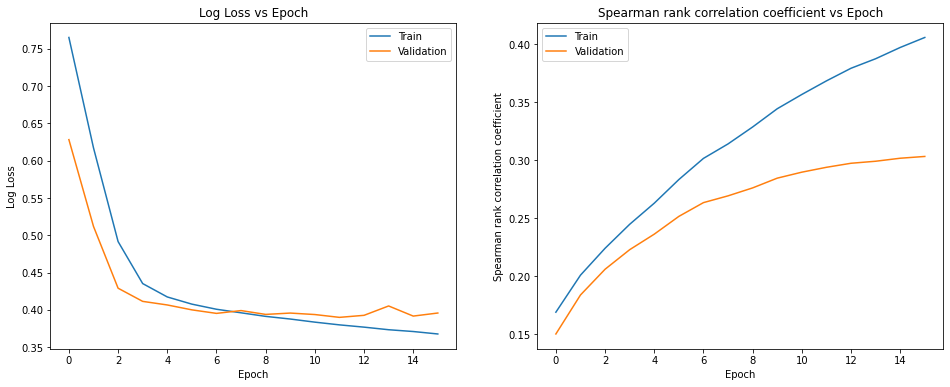

In [ ]:
epochs = history.epoch
metrics = history.history
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,6))
ax1.plot(epochs, metrics['loss'], label="Train")
ax1.plot(epochs, metrics['val_loss'], label="Validation")
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log Loss')
ax1.set_title('Log Loss vs Epoch')
ax2.plot(epochs, metrics['rho'], label="Train")
ax2.plot(epochs, metrics['val_rho'], label="Validation")
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Spearman rank correlation coefficient')
ax2.set_title('Spearman rank correlation coefficient vs Epoch')
plt.show()

In [ ]:
X_train_input_full = [sequence_train_full_q_title, sequence_train_full_q_body, sequence_train_full_answer, sequences_train_non_text_full]
model_1.fit(X_train_input_full, y_train_full, epochs=10, batch_size= 32, verbose=1, callbacks = callback_list)
model_1.save(filepath)

Epoch 1/10
190/190 [==============================] - 124s 654ms/step - loss: 0.6839
Epoch 2/10
190/190 [==============================] - 124s 654ms/step - loss: 0.4482
Epoch 3/10
190/190 [==============================] - 124s 654ms/step - loss: 0.4124
Epoch 4/10
190/190 [==============================] - 124s 653ms/step - loss: 0.4018
Epoch 5/10
190/190 [==============================] - 123s 649ms/step - loss: 0.3947
Epoch 6/10
190/190 [==============================] - 124s 652ms/step - loss: 0.3908
Epoch 7/10
190/190 [==============================] - 124s 653ms/step - loss: 0.3864
Epoch 8/10
190/190 [==============================] - 125s 658ms/step - loss: 0.3822
Epoch 9/10
190/190 [==============================] - 125s 656ms/step - loss: 0.3790
Epoch 10/10
190/190 [==============================] - 125s 657ms/step - loss: 0.3768


In [ ]:
def inference_baseline(test_data):
    '''Inference loop for the baseline model which gives prediction for a test datapoint'''
    embedding_q_title_test, num_words_q_title_test, sequence_test_q_title = create_text_embedding(
    test_data.question_title, vocabulary_size = 7500, max_sequence_length= 50, name = 'q_title', data_type = 'test')

    embedding_q_body_test, num_words_q_body_test, sequence_test_q_body = create_text_embedding(
    test_data.question_body, vocabulary_size = 25000, max_sequence_length= 1000,  name = 'q_body',  data_type = 'test')

    embedding_answer_test, num_words_answer_test, sequence_test_answer = create_text_embedding(
    test_data.answer, vocabulary_size = 35000, max_sequence_length= 1000,  name = 'answer', data_type = 'test')

    tokenizer_cat_test = pickle.load(open('tokenizer_category.pkl', 'rb'))
    sequences_test_cat_ohe = tokenizer_cat_test.texts_to_matrix(test_data.category)
    sequences_test_cat_ohe = np.asarray(pad_sequences(sequences_test_cat_ohe, maxlen= unique_cat_full))

    tokenizer_host_cat_test = pickle.load(open('tokenizer_host_category.pkl', 'rb'))
    sequences_test_host_cat_ohe = tokenizer_host_cat_test.texts_to_matrix(test_data.host_cat)
    sequences_test_host_cat_ohe = np.asarray(pad_sequences(sequences_test_host_cat_ohe, maxlen= unique_host_cat_full))

    for col in num_columns:
        filename = 'minmax_'+col+'.pkl'
        minmax = pickle.load(open(filename, 'rb'))
        test_data[col] = scalar.transform(test_data[col].values.reshape(-1, 1))

    sequences_test_rem =np.asarray([test_data[col].values for col in num_columns]).transpose()

    non_text_len_full = unique_cat_full+ unique_host_cat_full+7
    sequences_test_non_text = np.concatenate([sequences_test_cat_ohe, sequences_test_host_cat_ohe,
                                            sequences_test_rem], axis = 1).reshape(-1,73,1)

    X_test_input = [sequence_test_q_title, sequence_test_q_body, sequence_test_answer,  sequences_test_non_text]
    best_model = tf.keras.models.load_model("best_model_1.h5")
    y_test = best_model.predict(X_test_input)
    return y_test

In [ ]:
%%time
y_predicted = inference_baseline(X_test.iloc[[1]])

CPU times: user 8.54 s, sys: 955 ms, total: 9.49 s
Wall time: 9.62 s


In [ ]:
y_predicted_base = inference_baseline(X_test)

<h1>BERT</h1>


<h2>Training with the BERT Model</h2>

In [9]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
BERT_PATH = 'bert_base/'
tokenizer = BertTokenizer.from_pretrained(BERT_PATH+'bert-base-uncased-vocab.txt')


MAX_SEQUENCE_LENGTH = 384
def _convert_to_transformer_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformers"""
    
    def return_id(str1, str2, truncation_strategy, length):
        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    input_ids_q, input_masks_q, input_segments_q = return_id(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_a, input_masks_a, input_segments_a = return_id(
        answer, None, 'longest_first', max_sequence_length)
    
    return [input_ids_q, input_masks_q, input_segments_q,
            input_ids_a, input_masks_a, input_segments_a]

def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    '''Returns the input arrays to be used as input to the model'''
    input_ids_q, input_masks_q, input_segments_q = [], [], []
    input_ids_a, input_masks_a, input_segments_a = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        t, q, a = instance.question_title, instance.question_body, instance.answer

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = \
        _convert_to_transformer_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_q.append(ids_q)
        input_masks_q.append(masks_q)
        input_segments_q.append(segments_q)

        input_ids_a.append(ids_a)
        input_masks_a.append(masks_a)
        input_segments_a.append(segments_a)
        
    return [np.asarray(input_ids_q, dtype=np.int32), 
            np.asarray(input_masks_q, dtype=np.int32), 
            np.asarray(input_segments_q, dtype=np.int32),
            np.asarray(input_ids_a, dtype=np.int32), 
            np.asarray(input_masks_a, dtype=np.int32), 
            np.asarray(input_segments_a, dtype=np.int32)]

def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

def create_model2():
    keras.backend.clear_session()
    q_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    input_layer_non_text = Input(shape=(73,), name='nontext_input')
    
    non_text = tf.expand_dims(input_layer_non_text, axis = -1)
    non_text = Conv1D(64, 1, activation='relu', kernel_initializer=glorot_uniform(seed=42))(non_text)
    non_text = MaxPooling1D(2)(non_text)
    non_text = Conv1D(64, 3, activation='relu', kernel_initializer=glorot_uniform(seed=42))(non_text)
    non_text = MaxPooling1D(2)(non_text)
    non_text = Flatten()(non_text)

    
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertModel.from_pretrained(
        BERT_PATH+'bert-base-uncased-tf_model.h5', config=config)
    
    q_embedding = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
    a_embedding = bert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    
    q = GlobalAveragePooling1D()(q_embedding)
    a = GlobalAveragePooling1D()(a_embedding)
    
    x = Concatenate()([q, a, non_text])
    
    x = Dropout(0.3)(x)
    
    x = Dense(30, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(x)

    model = Model(inputs=[q_id, q_mask, q_atn, a_id, a_mask, a_atn, input_layer_non_text], outputs=x)
    
    return model

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [10]:
MAX_SEQUENCE_LENGTH = 384
output_categories = q_target_cols+a_target_cols
input_categories = ['question_title','question_body','answer']
outputs = compute_output_arrays(train, output_categories)
inputs = compute_input_arrays(X_train_full, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
#pickle.dump(tokenizer, open('bert_tokenizer.pkl', 'wb'))

inputs_all = [inp for inp in inputs]
inputs_all.append(sequences_train_non_text_full.squeeze())

6079it [00:28, 215.88it/s]


In [ ]:
model = create_model2()
model.summary()

Some weights of the model checkpoint at bert_base/bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert_base/bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nontext_input (InputLayer)      [(None, 73)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 73, 1)]      0           nontext_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 73, 64)       128         tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 36, 64)       0           conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
#Creating 5 folds for cross validation
gkf = GroupKFold(n_splits=5).split(X=X_train_full.question_body, groups=X_train_full.question_body)

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    if fold==2:

        train_inputs = [inputs_all[i][train_idx] for i in range(len(inputs_all))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs_all[i][valid_idx] for i in range(len(inputs_all))]
        valid_outputs = outputs[valid_idx]

        #Saving validation data to do the error analysis of the model
        pickle.dump((valid_inputs,valid_idx), open('valid_inputs.pkl','wb'))
        pickle.dump(valid_outputs, open('valid_outputs.pkl','wb'))

        model = create_model2()
        custom_callback = CustomCallback(train_data = (train_inputs, train_outputs),
                                 valid_data=(valid_inputs, valid_outputs), training =True)
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')
        model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5))
        model.fit(train_inputs, train_outputs, validation_data = (valid_inputs, valid_outputs), epochs=3,
                  batch_size=4, callbacks = [custom_callback, tensorboard_callback])
        model.save_weights(f'bert-final-{fold}.h5')

Some weights of the model checkpoint at bert_base/bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert_base/bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
1216/1216 [==============================] - 3095s 3s/step - loss: 0.4094 - val_loss: 0.3771 - rho: 0.3725 - val_rho: 0.3419
Epoch 2/3
1216/1216 [==============================] - 3082s 3s/step - loss: 0.3775 - val_loss: 0.3698 - rho: 0.4137 - val_rho: 0.3650
Epoch 3/3
1216/1216 [==============================] - 3087s 3s/step - loss: 0.3641 - val_loss: 0.3678 - rho: 0.4457 - val_rho: 0.3769


In [11]:
 def inference_model2(test_data):
    '''Inference loop for the BERT fine tuned model'''
    MAX_SEQUENCE_LENGTH = 384
    output_categories = q_target_cols+a_target_cols
    input_categories = ['question_title','question_body','answer']
    
    tokenizer = pickle.load(open('bert_tokenizer.pkl', 'rb'))
    test_inputs = compute_input_arrays(test_data, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
    test_inputs_all = [inp for inp in test_inputs]

    tokenizer_cat_test = pickle.load(open('tokenizer_category.pkl', 'rb'))
    sequences_test_cat_ohe = tokenizer_cat_test.texts_to_matrix(test_data.category)
    sequences_test_cat_ohe = np.asarray(pad_sequences(sequences_test_cat_ohe, maxlen= unique_cat_full))

    tokenizer_host_cat_test = pickle.load(open('tokenizer_host_category.pkl', 'rb'))
    sequences_test_host_cat_ohe = tokenizer_host_cat_test.texts_to_matrix(test_data.host_cat)
    sequences_test_host_cat_ohe = np.asarray(pad_sequences(sequences_test_host_cat_ohe, maxlen= unique_host_cat_full))

    for col in num_columns:
        filename = 'minmax_'+col+'.pkl'
        minmax = pickle.load(open(filename, 'rb'))
        test_data[col] = scalar.transform(test_data[col].values.reshape(-1, 1))

    sequences_test_rem =np.asarray([test_data[col].values for col in num_columns]).transpose()

    sequences_test_non_text = np.concatenate([sequences_test_cat_ohe, sequences_test_host_cat_ohe,
                                            sequences_test_rem], axis = 1)
    
    test_inputs_all.append(sequences_test_non_text)
    
    model = create_model2()
    model.load_weights('bert-final-2.h5')
    y_test = model.predict(test_inputs_all)
    return y_test

In [ ]:
%%time
y_prediced_2 = inference_model2(X_test.iloc[[1]])

1it [00:00, 145.61it/s]
Some weights of the model checkpoint at bert_base/bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert_base/bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


CPU times: user 16.2 s, sys: 1.36 s, total: 17.6 s
Wall time: 18.8 s


In [12]:
y_prediced_b = inference_model2(X_test)

476it [00:02, 204.96it/s]
Some weights of the model checkpoint at bert_base/bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert_base/bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
valid_inputs,valid_idx = pickle.load(open('valid_inputs.pkl', 'rb'))
valid_outputs = pickle.load(open('valid_outputs.pkl', 'rb'))
model = create_model2()
model.load_weights('bert-final-2.h5')
valid_pred = model.predict(valid_inputs, batch_size= 4)

Some weights of the model checkpoint at bert_base/bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert_base/bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pickle.dump(valid_pred,open('valid_pred.pkl','wb'))
valid_pred = pickle.load(open("valid_pred.pkl", 'rb'))

<h2>Error Analysis</h2>

In [15]:
valid_corr = dict()
for col in range(30):
    valid_corr[(q_target_cols+a_target_cols)[col]] = spearmanr(valid_outputs[:,col], valid_pred[:,col]).correlation

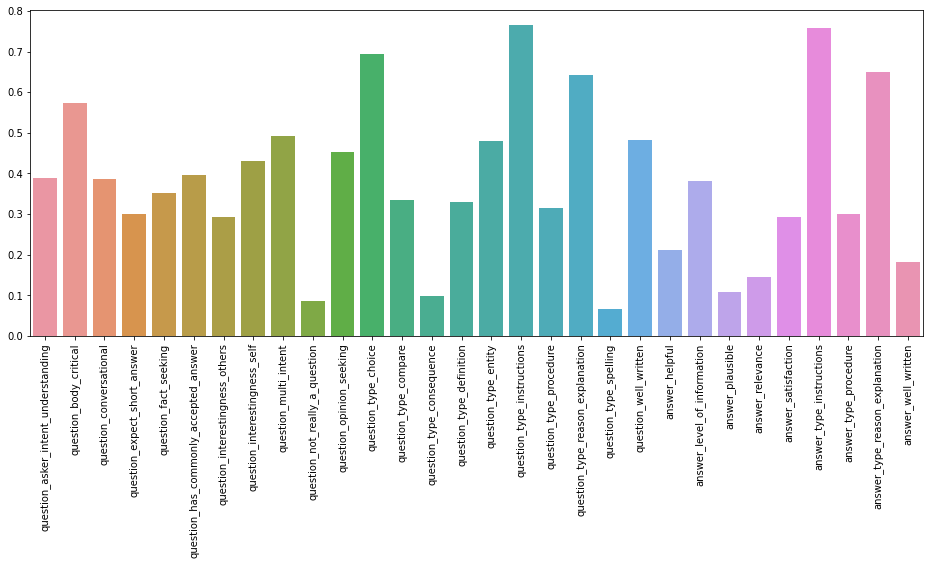

In [16]:
plt.figure(figsize=(16,6))
sns.barplot(list(valid_corr.keys()), list(valid_corr.values()))
plt.xticks(rotation = 90)
plt.show()

**Poorly performing targets variables**
1. question_type_spelling
2. question_not_really_a_question
3. question_type_consequence
4. answer_plausible

**Targets variables with good performance**
1. question_type_choice
2. question_type_instructions
3. question_type_reason_explanation
4. answer_type_instruction
5. answer_type_reason_explanation

In [27]:
X_valid = X_train_full.iloc[valid_idx,:]
valid_diff = np.abs(valid_outputs-valid_pred)
row_diff = []
for row in range(1216):    
    row_diff.append(valid_diff[row,:].mean())

row_diff = np.asarray(row_diff)
#Top 10 percentile
mask_best = row_diff<0.089
#Bottom 10 percentile
mask_worst = row_diff>0.175

X_good = X_valid.loc[mask_best,:]
X_good['performance'] = 'good'
X_poor = X_valid.loc[mask_worst,:]
X_poor['performance'] = 'poor'
X_total = pd.concat([X_good, X_poor], axis=0)

num_columns = ['question_n_words', 'answer_n_words', 'questitle_n_words', 'question_number_count',
              'answer_number_count', 'question_unique_word', 'answer_unique_word']

for col in num_columns:
    scalar = MinMaxScaler()
    scalar.fit(X_total[col].values.reshape(-1, 1))
    X_total[col] = scalar.transform(X_total[col].values.reshape(-1, 1))

X_total = pd.get_dummies(data=X_total, columns=['host_cat', 'category'])
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf-8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
#glove_model = loadGloveModel('glove.6B.300d.txt')
glove_words = set(glove_model.keys())

def glove_embeddings(x):
    list_of_sentance = []
    for item in x:
        list_of_sentance.append(item.split())
    sent_vectors = []
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(300)
        count=0
        for word in sent:
            if word in glove_words:
                count+=1
                vec = glove_model[word]
                sent_vec+= vec
            if count!=0:
                sent_vec/=count
        sent_vectors.append(sent_vec)
    return sent_vectors

qb = glove_embeddings(X_total.loc[:,'question_body'])
qt = glove_embeddings(X_total.loc[:,'question_title'])
ans = glove_embeddings(X_total.loc[:,'answer'])

X_text = np.append(ans, np.append(qb, qt, axis=1), axis=1)
X_nontext = X_total.drop(['question_body', 'answer', 'question_title', 'performance'], axis = 1).values
X_prep = np.append(X_text, X_nontext, axis = 1)

tsne = TSNE(n_components=2, learning_rate=50, perplexity=30, random_state=42)
X_reduced = tsne.fit_transform(X_prep, X_total['performance'].values)
X_reduced_df = pd.DataFrame(X_reduced, columns = ['Feature_1', 'Feature_2'])
X_reduced_df['performance'] = X_total['performance'].values

100%|██████████| 250/250 [00:00<00:00, 1711.00it/s]


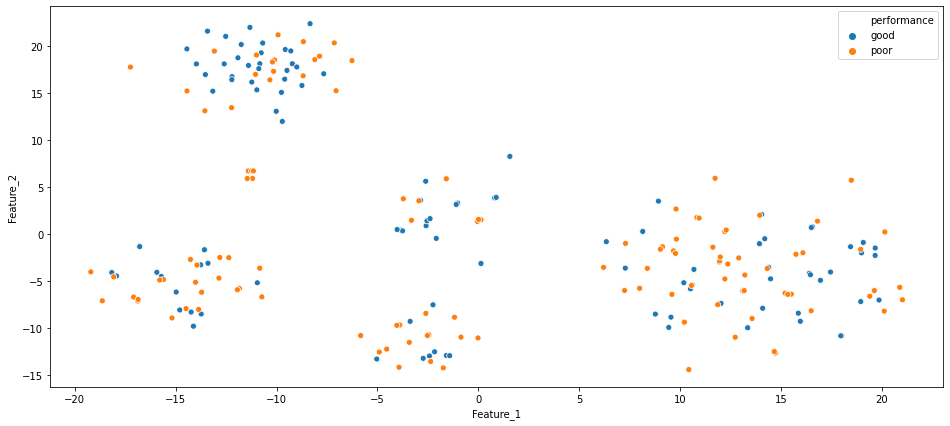

In [28]:
plt.figure(figsize = (16,7))
sns.scatterplot(data=X_reduced_df, x = 'Feature_1', y = 'Feature_2', hue = 'performance')
plt.show()

**It is difficult to seperate the datapoints based upon the performance.**

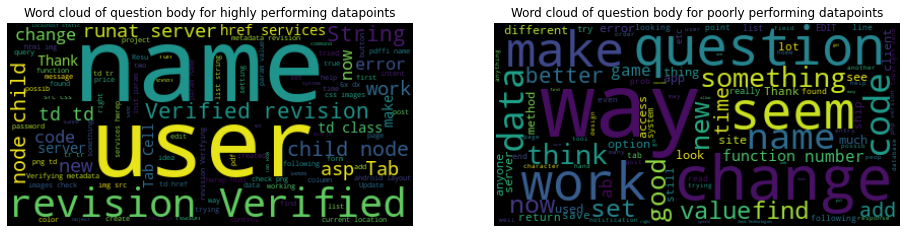

In [35]:
from wordcloud import WordCloud ,STOPWORDS
from bs4 import BeautifulSoup
stopwords = set(STOPWORDS)
## Word cloud of question bodies##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know", "fi", "ms", "id"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in X_good.question_body)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_words=100).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of question body for highly performing datapoints')

##Word cloud for answers##
text = ' '.join(BeautifulSoup(txt).get_text() for txt in X_poor.question_body)

wordcloud = WordCloud(stopwords=stopwords, max_words=100).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of question body for poorly performing datapoints')

plt.show()

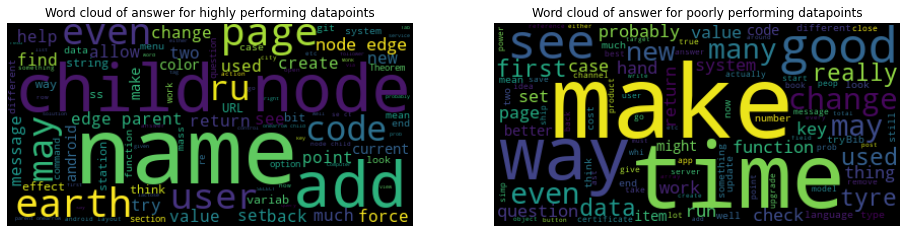

In [34]:
stopwords = set(STOPWORDS)
## Word cloud of question bodies##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know", "fi", "ms", "id"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in X_good.answer)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_words=100).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of answer for highly performing datapoints')

##Word cloud for answers##
text = ' '.join(BeautifulSoup(txt).get_text() for txt in X_poor.answer)

wordcloud = WordCloud(stopwords=stopwords, max_words=100).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of answer for poorly performing datapoints')

plt.show()

The word clouds of the question bodies of the well performing and poorly performing data points seems different. For the good performing ones the words are more domain specific (technology) while in case of poorly performing ones the words seem more generic. Same can be said for the corresponding answers.

<h2>Model using BERT embeddings</h2>

In [ ]:
BERT_PATH = 'bert_base/'
tokenizer = BertTokenizer.from_pretrained(BERT_PATH+'bert-base-uncased-vocab.txt')
MAX_SEQUENCE_LENGTH = 384
def bert_embedding():
    '''Returns 768 dimensional the BERT embeddings of the texts using the sequence output'''
    keras.backend.clear_session()
    q_id = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False
    
    bert_model = TFBertModel.from_pretrained(
        BERT_PATH+'bert-base-uncased-tf_model.h5', config=config)
    
    q_embedding = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
    a_embedding = bert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]

    q = GlobalAveragePooling1D()(q_embedding)
    a = GlobalAveragePooling1D()(a_embedding)
    x= Concatenate()([q,a])
    model = Model(inputs = [q_id, q_mask, q_atn, a_id, a_mask, a_atn], outputs = x)

    return model

def create_model3():
    keras.backend.clear_session()
    text_embedding = Input((1536,), dtype=tf.float32)
    input_layer_non_text = Input(shape=(73,), name='nontext_input')
    
    non_text = tf.expand_dims(input_layer_non_text, axis = -1)
    non_text = Conv1D(64, 1, activation='relu', kernel_initializer=glorot_uniform(seed=42))(non_text)
    non_text = MaxPooling1D(2)(non_text)
    non_text = Conv1D(64, 3, activation='relu', kernel_initializer=glorot_uniform(seed=42))(non_text)
    non_text = MaxPooling1D(2)(non_text)
    non_text = Flatten()(non_text)  
    
    x = Concatenate()([text_embedding, non_text])

    x = Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=42))(x)

    x= Dropout(0.3)(x)
    
    x = Dense(30, activation = 'sigmoid', kernel_initializer=glorot_uniform(seed=42))(x)

    model = tf.keras.models.Model(inputs=[text_embedding, input_layer_non_text], outputs=x)

    return model

bert_output = bert_embedding()
bert_output.summary()

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Some weights of the model checkpoint at bert_base/bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert_base/bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384)]        0                                            
______________________________________________________________________________________________

In [ ]:
model4 = create_model3()
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1536)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           98368       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64)           0           dense[0][0]                      
__________________________________________________________________________________________________
nontext_input (InputLayer)      [(None, 73)]         0                                            
______________________________________________________________________________________________

In [ ]:
%%time
text_embeddings_train = bert_output.predict(inputs, batch_size = 8)#Getting the text embeddings from the BERT model
#text_embeddings_test = bert_output.predict(test_inputs, batch_size = 8)

CPU times: user 1min 21s, sys: 23.9 s, total: 1min 45s
Wall time: 6min 38s


In [ ]:
#pickle.dump((text_embeddings_train),open('text_embeddings_train.pkl','wb'))
#pickle.dump((text_embeddings_test),open('text_embeddings_test.pkl','wb'))

text_embeddings_train = pickle.load(open("text_embeddings_train.pkl", 'rb'))
#text_embeddings_test = pickle.load(open("text_embeddings_test.pkl", 'rb'))

#Adding non-text features to our inputs
inputs_new = [text_embeddings_train, sequences_train_non_text_full.squeeze()]
#test_inputs_new = [text_embeddings_test, sequences_test_non_text.squeeze()]

In [ ]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
gkf = GroupKFold(n_splits=3).split(X=X_train_full.question_body, groups=X_train_full.question_body)

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold<1:
        train_inputs = [inputs_new[i][train_idx] for i in range(len(inputs_new))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs_new[i][valid_idx] for i in range(len(inputs_new))]
        valid_outputs = outputs[valid_idx]
        custom_callback = CustomCallback(train_data = (train_inputs, train_outputs),
                                    valid_data=(valid_inputs, valid_outputs), training =True)
        model = create_model3()
        model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-3))
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')
        earlyStop = EarlyStopping()
        model.fit(train_inputs, train_outputs, validation_data = (valid_inputs, valid_outputs), 
                epochs=20, batch_size=64, callbacks = [custom_callback, tensorboard_callback])
        model.save_weights(f'new-bert-{fold}.h5')

Epoch 1/20
64/64 [==============================] - 1s 20ms/step - loss: 0.5028 - val_loss: 0.4119 - rho: 0.2370 - val_rho: 0.2058
Epoch 2/20
64/64 [==============================] - 1s 16ms/step - loss: 0.4295 - val_loss: 0.4035 - rho: 0.2709 - val_rho: 0.2361
Epoch 3/20
64/64 [==============================] - 1s 15ms/step - loss: 0.4147 - val_loss: 0.3983 - rho: 0.2921 - val_rho: 0.2531
Epoch 4/20
64/64 [==============================] - 1s 15ms/step - loss: 0.4070 - val_loss: 0.3946 - rho: 0.3086 - val_rho: 0.2657
Epoch 5/20
64/64 [==============================] - 1s 15ms/step - loss: 0.4015 - val_loss: 0.3930 - rho: 0.3213 - val_rho: 0.2748
Epoch 6/20
64/64 [==============================] - 1s 15ms/step - loss: 0.3982 - val_loss: 0.3915 - rho: 0.3309 - val_rho: 0.2817
Epoch 7/20
64/64 [==============================] - 1s 15ms/step - loss: 0.3952 - val_loss: 0.3901 - rho: 0.3390 - val_rho: 0.2872
Epoch 8/20
64/64 [==============================] - 1s 15ms/step - loss: 0.3926 - v

In [ ]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
gkf = GroupKFold(n_splits=3).split(X=X_train_full.question_body, groups=X_train_full.question_body)

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold<1:
        train_inputs = [inputs_new[i][train_idx] for i in range(len(inputs_new))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs_new[i][valid_idx] for i in range(len(inputs_new))]
        valid_outputs = outputs[valid_idx]
        custom_callback = CustomCallback(train_data = (train_inputs, train_outputs),
                                    valid_data=(valid_inputs, valid_outputs), training =True)
        model = create_model3()
        model.compile(loss='mean_absolute_error', optimizer = Adam(learning_rate=5e-4))
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')
        earlyStop = EarlyStopping()
        model.fit(train_inputs, train_outputs, validation_data = (valid_inputs, valid_outputs), 
                epochs=50, batch_size=64, callbacks = [custom_callback, tensorboard_callback])
        model.save_weights(f'new-bert-{fold}.h5')

Epoch 1/50
64/64 [==============================] - 1s 14ms/step - loss: 0.3305 - val_loss: 0.2040 - rho: 0.1544 - val_rho: 0.1268
Epoch 2/50
64/64 [==============================] - 1s 10ms/step - loss: 0.2486 - val_loss: 0.1754 - rho: 0.1915 - val_rho: 0.1569
Epoch 3/50
64/64 [==============================] - 1s 10ms/step - loss: 0.2219 - val_loss: 0.1676 - rho: 0.2141 - val_rho: 0.1737
Epoch 4/50
64/64 [==============================] - 1s 10ms/step - loss: 0.2066 - val_loss: 0.1681 - rho: 0.2347 - val_rho: 0.1891
Epoch 5/50
64/64 [==============================] - 1s 10ms/step - loss: 0.1955 - val_loss: 0.1569 - rho: 0.2466 - val_rho: 0.1964
Epoch 6/50
64/64 [==============================] - 1s 10ms/step - loss: 0.1882 - val_loss: 0.1525 - rho: 0.2579 - val_rho: 0.2042
Epoch 7/50
64/64 [==============================] - 1s 10ms/step - loss: 0.1833 - val_loss: 0.1539 - rho: 0.2677 - val_rho: 0.2111
Epoch 8/50
64/64 [==============================] - 1s 10ms/step - loss: 0.1779 - v

In [ ]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
gkf = GroupKFold(n_splits=3).split(X=X_train_full.question_body, groups=X_train_full.question_body)

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold<1:
        train_inputs = [inputs_new[i][train_idx] for i in range(len(inputs_new))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs_new[i][valid_idx] for i in range(len(inputs_new))]
        valid_outputs = outputs[valid_idx]
        custom_callback = CustomCallback(train_data = (train_inputs, train_outputs),
                                    valid_data=(valid_inputs, valid_outputs), training =True)
        model = create_model3()
        model.compile(loss='cosine_similarity', optimizer = Adam(learning_rate=1e-3))
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')
        earlyStop = EarlyStopping()
        model.fit(train_inputs, train_outputs, validation_data = (valid_inputs, valid_outputs), 
                epochs=15, batch_size=64, callbacks = [custom_callback, tensorboard_callback])
        model.save_weights(f'new-bert-{fold}.h5')

Epoch 1/15
64/64 [==============================] - 1s 21ms/step - loss: -0.7988 - val_loss: -0.9258 - rho: 0.1517 - val_rho: 0.1281
Epoch 2/15
64/64 [==============================] - 1s 16ms/step - loss: -0.8934 - val_loss: -0.9300 - rho: 0.1690 - val_rho: 0.1423
Epoch 3/15
64/64 [==============================] - 1s 15ms/step - loss: -0.9099 - val_loss: -0.9321 - rho: 0.1840 - val_rho: 0.1548
Epoch 4/15
64/64 [==============================] - 1s 16ms/step - loss: -0.9183 - val_loss: -0.9339 - rho: 0.1953 - val_rho: 0.1643
Epoch 5/15
64/64 [==============================] - 1s 16ms/step - loss: -0.9240 - val_loss: -0.9346 - rho: 0.2034 - val_rho: 0.1708
Epoch 6/15
64/64 [==============================] - 1s 16ms/step - loss: -0.9277 - val_loss: -0.9356 - rho: 0.2103 - val_rho: 0.1760
Epoch 7/15
64/64 [==============================] - 1s 16ms/step - loss: -0.9306 - val_loss: -0.9364 - rho: 0.2160 - val_rho: 0.1801
Epoch 8/15
64/64 [==============================] - 1s 16ms/step - lo

In [ ]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
gkf = GroupKFold(n_splits=3).split(X=X_train_full.question_body, groups=X_train_full.question_body)

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold<1:
        train_inputs = [inputs_new[i][train_idx] for i in range(len(inputs_new))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs_new[i][valid_idx] for i in range(len(inputs_new))]
        valid_outputs = outputs[valid_idx]
        custom_callback = CustomCallback(train_data = (train_inputs, train_outputs),
                                    valid_data=(valid_inputs, valid_outputs), training =True)
        model = create_model3()
        model.compile(loss='huber_loss', optimizer = Adam(learning_rate=1e-3))
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')
        earlyStop = EarlyStopping()
        model.fit(train_inputs, train_outputs, validation_data = (valid_inputs, valid_outputs), 
                epochs=15, batch_size=64, callbacks = [custom_callback, tensorboard_callback])
        model.save_weights(f'new-bert-{fold}.h5')

Epoch 1/15
64/64 [==============================] - 1s 20ms/step - loss: 0.0740 - val_loss: 0.0313 - rho: 0.2040 - val_rho: 0.1697
Epoch 2/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0432 - val_loss: 0.0321 - rho: 0.2378 - val_rho: 0.1931
Epoch 3/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0374 - val_loss: 0.0320 - rho: 0.2630 - val_rho: 0.2113
Epoch 4/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0345 - val_loss: 0.0272 - rho: 0.2818 - val_rho: 0.2218
Epoch 5/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0323 - val_loss: 0.0295 - rho: 0.2925 - val_rho: 0.2273
Epoch 6/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0311 - val_loss: 0.0265 - rho: 0.3047 - val_rho: 0.2352
Epoch 7/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0303 - val_loss: 0.0280 - rho: 0.3152 - val_rho: 0.2422
Epoch 8/15
64/64 [==============================] - 1s 15ms/step - loss: 0.0297 - v

In [ ]:
 def inference_model3(test_data):
    '''Inference loop for the BERT fine tuned model'''
    
    tokenizer = pickle.load(open('bert_tokenizer.pkl', 'rb'))
    test_inputs = compute_input_arrays(test_data, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
    text_embeddings_test = bert_output.predict(test_inputs, batch_size = 8)

    tokenizer_cat_test = pickle.load(open('tokenizer_category.pkl', 'rb'))
    sequences_test_cat_ohe = tokenizer_cat_test.texts_to_matrix(test_data.category)
    sequences_test_cat_ohe = np.asarray(pad_sequences(sequences_test_cat_ohe, maxlen= unique_cat_full))

    tokenizer_host_cat_test = pickle.load(open('tokenizer_host_category.pkl', 'rb'))
    sequences_test_host_cat_ohe = tokenizer_host_cat_test.texts_to_matrix(test_data.host_cat)
    sequences_test_host_cat_ohe = np.asarray(pad_sequences(sequences_test_host_cat_ohe, maxlen= unique_host_cat_full))

    for col in num_columns:
        filename = 'minmax_'+col+'.pkl'
        minmax = pickle.load(open(filename, 'rb'))
        test_data[col] = scalar.transform(test_data[col].values.reshape(-1, 1))

    sequences_test_rem =np.asarray([test_data[col].values for col in num_columns]).transpose()

    sequences_test_non_text = np.concatenate([sequences_test_cat_ohe, sequences_test_host_cat_ohe,
                                            sequences_test_rem], axis = 1)
    
    test_inputs_new = [text_embeddings_test, sequences_test_non_text]
    
    model = create_model3()
    model.load_weights('new-bert-1.h5')
    y_test = model.predict(test_inputs_new)
    return y_test

In [ ]:
%%time
y_predicted_3 = inference_model3(X_test.iloc[[1]])

1it [00:00, 135.84it/s]


CPU times: user 392 ms, sys: 32.8 ms, total: 424 ms
Wall time: 497 ms


In [ ]:
y_predicted_be = inference_model3(X_test)

476it [00:02, 227.72it/s]


<h2>Training Albert Model</h2>


In [ ]:
albert_path = 'albert_base/'
tokenizer = AlbertTokenizer.from_pretrained(albert_path+'30k-clean.model', do_lower_case=True)
MAX_SEQUENCE_LENGTH = 128
output_categories = q_target_cols+a_target_cols
input_categories = ['question_title','question_body','answer']
#outputs = compute_output_arrays(train, output_categories)
#inputs = compute_input_arrays(X_train_full, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
#test_inputs = compute_input_arrays(X_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)

inputs_all = [inp for inp in inputs]
inputs_all.append(sequences_train_non_text_full.squeeze())

Calling AlbertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [ ]:
def create_model_albert():
    
    keras.backend.clear_session()
    MAX_SEQUENCE_LENGTH = 128
    q_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    input_layer_non_text = Input(shape=(73,), name='nontext_input')
    
    non_text = tf.expand_dims(input_layer_non_text, axis = -1)
    non_text = Conv1D(64, 1, activation='relu', kernel_initializer=glorot_uniform(seed=42))(non_text)
    non_text = MaxPooling1D(2)(non_text)
    non_text = Conv1D(64, 3, activation='relu', kernel_initializer=glorot_uniform(seed=42))(non_text)
    non_text = MaxPooling1D(2)(non_text)
    non_text = Flatten()(non_text)

    
    config = AlbertConfig.from_json_file(albert_path+'albert_config.json')
    config.output_hidden_states = False

    albert_model = TFAlbertModel.from_pretrained(albert_path+'albert-base-v2-tf_model.h5', config = config)
    
    q_embedding = albert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
    a_embedding = albert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    
    q = GlobalAveragePooling1D()(q_embedding)
    a = GlobalAveragePooling1D()(a_embedding)
    
    x = Concatenate()([q, a, non_text])
    
    x = Dropout(0.2)(x)
    
    x = Dense(30, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(x)

    model = Model(inputs=[q_id, q_mask, q_atn, a_id, a_mask, a_atn, input_layer_non_text], outputs=x)
    
    return model

albert_model = create_model_albert()
albert_model.summary()

Some weights of the model checkpoint at albert_base/albert-base-v2-tf_model.h5 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the model checkpoint at albert_base/albert-base-v2-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nontext_input (InputLayer)      [(None, 73)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 73, 1)]      0           nontext_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 73, 64)       128         tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 36, 64)       0           conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
#https://www.kaggle.com/akensert/quest-bert-base-tf2-0
#Creating 5 folds for cross validation
gkf = GroupKFold(n_splits=5).split(X=X_train_full.question_body, groups=X_train_full.question_body)

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    if fold<2:

        train_inputs = [inputs_all[i][train_idx] for i in range(len(inputs_all))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs_all[i][valid_idx] for i in range(len(inputs_all))]
        valid_outputs = outputs[valid_idx]

        model = create_model_albert()
        custom_callback = CustomCallback(train_data = (train_inputs, train_outputs),
                                 valid_data=(valid_inputs, valid_outputs), training =True)
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,  update_freq='epoch')
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-5))
        model.fit(train_inputs, train_outputs, validation_data=(valid_inputs, valid_outputs), 
                    epochs=5, batch_size=8, callbacks = [custom_callback, tensorboard_callback])
        model.save_weights(f'albert-{fold}.h5')

Epoch 1/5
608/608 [==============================] - 962s 2s/step - loss: 0.4064 - val_loss: 0.3849 - rho: 0.3579 - val_rho: 0.3219
Epoch 2/5
608/608 [==============================] - 944s 2s/step - loss: 0.3798 - val_loss: 0.3797 - rho: 0.3948 - val_rho: 0.3452
Epoch 3/5
608/608 [==============================] - 941s 2s/step - loss: 0.3683 - val_loss: 0.3761 - rho: 0.4229 - val_rho: 0.3556
Epoch 4/5
608/608 [==============================] - 941s 2s/step - loss: 0.3585 - val_loss: 0.3779 - rho: 0.4472 - val_rho: 0.3600
Epoch 5/5
608/608 [==============================] - 944s 2s/step - loss: 0.3494 - val_loss: 0.3805 - rho: 0.4717 - val_rho: 0.3615
Epoch 1/5
608/608 [==============================] - 962s 2s/step - loss: 0.4060 - val_loss: 0.3821 - rho: 0.3573 - val_rho: 0.3225
Epoch 2/5
608/608 [==============================] - 946s 2s/step - loss: 0.3808 - val_loss: 0.3778 - rho: 0.3937 - val_rho: 0.3422
Epoch 3/5
608/608 [==============================] - 943s 2s/step - loss: 0.

In [ ]:
 def inference_model_albert(test_data):
    '''Inference loop for the BERT fine tuned model'''
    test_inputs = compute_input_arrays(test_data, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
    test_inputs_all = [inp for inp in test_inputs]

    tokenizer_cat_test = pickle.load(open('tokenizer_category.pkl', 'rb'))
    sequences_test_cat_ohe = tokenizer_cat_test.texts_to_matrix(test_data.category)
    sequences_test_cat_ohe = np.asarray(pad_sequences(sequences_test_cat_ohe, maxlen= unique_cat_full))

    tokenizer_host_cat_test = pickle.load(open('tokenizer_host_category.pkl', 'rb'))
    sequences_test_host_cat_ohe = tokenizer_host_cat_test.texts_to_matrix(test_data.host_cat)
    sequences_test_host_cat_ohe = np.asarray(pad_sequences(sequences_test_host_cat_ohe, maxlen= unique_host_cat_full))

    for col in num_columns:
        filename = 'minmax_'+col+'.pkl'
        minmax = pickle.load(open(filename, 'rb'))
        test_data[col] = scalar.transform(test_data[col].values.reshape(-1, 1))

    sequences_test_rem =np.asarray([test_data[col].values for col in num_columns]).transpose()

    sequences_test_non_text = np.concatenate([sequences_test_cat_ohe, sequences_test_host_cat_ohe,
                                            sequences_test_rem], axis = 1)
    
    test_inputs_all.append(sequences_test_non_text)
    
    model = create_model_albert()
    model.load_weights('albert-0.h5')
    y_test = model.predict(test_inputs_all)
    return y_test

In [ ]:
%%time
y_predicted_alb = inference_model_albert(X_test.iloc[[1]])

1it [00:00, 236.86it/s]


CPU times: user 14 s, sys: 300 ms, total: 14.3 s
Wall time: 16.3 s


In [ ]:
y_predicted_a = inference_model_albert(X_test)

476it [00:01, 326.09it/s]
Some weights of the model checkpoint at albert_base/albert-base-v2-tf_model.h5 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the model checkpoint at albert_base/albert-base-v2-tf_model.h5.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
#pickle.dump(y_predicted_base,open('y_predicted_base.pkl','wb'))
y_predicted_base = pickle.load(open("y_predicted_base.pkl", 'rb'))

#pickle.dump(y_prediced_b,open('y_prediced_b.pkl','wb'))
y_prediced_b = pickle.load(open("y_prediced_b.pkl", 'rb'))

#pickle.dump(y_predicted_a,open('y_predicted_a.pkl','wb'))
y_predicted_a = pickle.load(open("y_predicted_a.pkl", 'rb'))

#pickle.dump(y_predicted_be,open('y_predicted_be.pkl','wb'))
y_predicted_be = pickle.load(open("y_predicted_be.pkl", 'rb'))

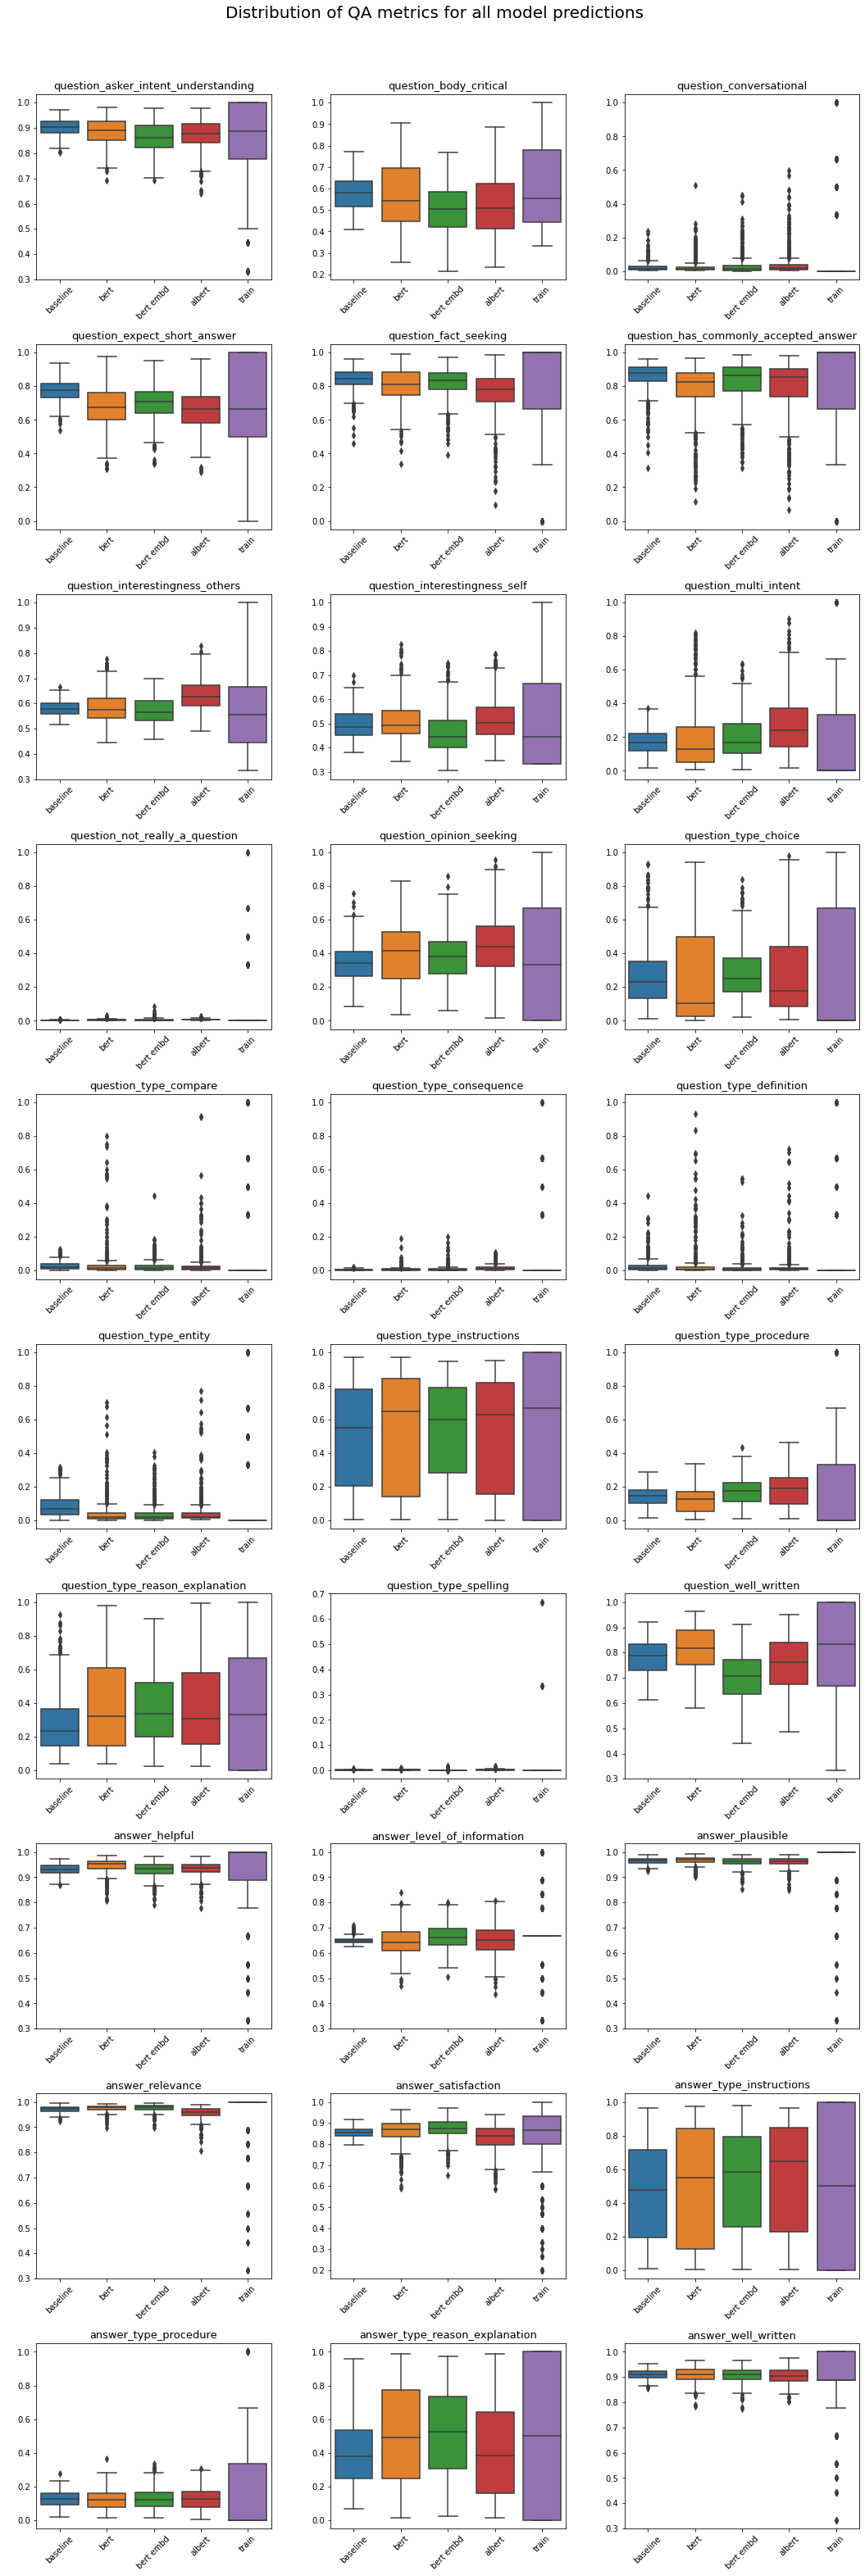

In [ ]:
import matplotlib.gridspec as gridspec
import seaborn as sns

model_type = ['baseline']*476+['bert']*476+['bert embd']*476+['albert']*476+['train']*6079
cols = q_target_cols+a_target_cols
comp_df = pd.DataFrame(np.vstack([y_predicted_base, y_prediced_b, y_predicted_be, y_predicted_a, y_train_full.values]),columns = cols)
comp_df['model_type'] = model_type
grid = gridspec.GridSpec(10,3)

plt.figure(figsize=(18,10*5))
count=0
plt.suptitle('Distribution of QA metrics for all model predictions', size=20)
for n, col in enumerate(cols):
    ax = plt.subplot(grid[count])
    sns.boxplot(y=col, x='model_type', data = comp_df)
    ax.set_title(str(col), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.subplots_adjust(top = 0.95, hspace=.35, wspace=.25)
plt.show()

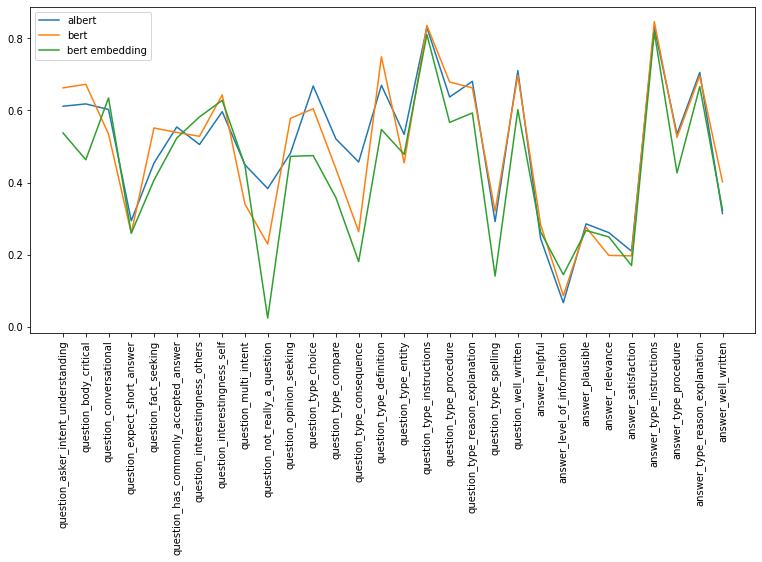

In [ ]:
alb_cor = []
bert_cor = []
bert_emb_cor = []
for i in range(30):
    alb_cor.append(np.corrcoef(y_predicted_a[:,i], y_predicted_base[:,i])[0][1])
    bert_cor.append(np.corrcoef(y_prediced_b[:,i], y_predicted_base[:,i])[0][1])
    bert_emb_cor.append(np.corrcoef(y_predicted_be[:,i], y_predicted_base[:,i])[0][1])

plt.figure(figsize = (13,6))
plt.plot(q_target_cols+a_target_cols,alb_cor, label = 'albert')
plt.plot(q_target_cols+a_target_cols, bert_cor, label = 'bert')
plt.plot(q_target_cols+a_target_cols, bert_emb_cor, label = 'bert embedding')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

<h2>Steps for making baseline model</h2>

1. Data Preprocessing
    - Text cleaning:removing HTML tags, numbers, decontract contracted words
    - Feature Engineering: Creating features like total number of words, number of unique words, count of numbers in any  in question/answer. Also getting the host category from the host.
    - Getting the train and validation data by splitting
2. Making the data model ready
    - Creating embedding: For text features 300 dim GloVe embedding is done with question body and answers having sequence ength of 1000 and question title having sequence length of 100. These values are chosen based on the disributon of the number of words in questions and answers. 
    - Encoding categorical features: Creating one hot encoding for the categorical features using keras preprocessing (Tokenizer)
    - Normalization of numerical variables: Minmax scaling of the numberical features are done to get better results
3. Building Model
    - Created custom model by using seperate Bidirectional LSTM layers for the three text features and concatenating them
    - Used Conv1D layer for the categorical and numerical features
    - Concatenating the results of these two layers and getting the output form a 30 dimensional hidden layer with sigmoid activation after being passed through a couple of dense layers.
4. Building Model
    - BATCH SIZE of 32
    - Custom Callback to add custom metrics (rho) to logs and history
    - Model checkpoint an dearly stopping callbacks are also implemented.


<h2>Observations</h2>

1. The baseline model gives validation rho of around 0.32
2. Since it is only a baseline model it has been kept simple. Tried using Conv1D on the sequence outputs of LSTM but it lead to too many parameters and negligible improvement of performance.
3. Our best model should be able to achieve a validation rho higher than 0.32.


<h2>Fine Tuning BERT base and ALBERT base models</h2>

<b>ALBERT</b><br>

1. Sequence length of 128 is used which is the maximum sequence length for Albert base model. Number of tunable parameters is around 11 millions.
2. Used cross validation instead of train stest split because this gives a better idea about the whole dataset.
3. Number of epochs is kept 3 so that the model runs within stipulated ime of 2 hours as per the competition rules.

<h2>Observation</h2>

1. Fine tuning performs better compared to BERT embeddings and also the baseline model.
2. We get validation rho in the range of 0.31-0.35.

<b>BERT</b><br>

1. Sequence length of 384 is used instead of maximum of 512 to avoid memory error. The batch size is also kept small to for the same reason. Number of tunable parameters is around 109M.
2. Used cross validation instead of train stest split because this gives a better idea about the whole dataset.
3. Number of epochs is kept 3 so that the model runs within stipulated ime of 2 hours as per the competition rules.

<h2>Observation</h2>

1. Fine tuning performs better compared to using BERT embedded features and Albert fine tuned model and training time is much higher.
2. We get validation rho in the range of 0.37-0.38.

In [36]:
#%tensorboard --logdir 'logs/fit' --host localhost